In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv("batch_results.csv")
df10 = df[df["Step"]% 10==0]  # only include every 10th step for analysis
df10.head()

,RunId,iteration,Step,width,height,seed,authority_density,reliability_min,reliability_max,Mean Knowledge,Mean Behavior,Net Health Belief
0,0,0,0,50,50,0,0.0,-1.0,0.0,-0.000249,0.5136,0.019852
10,0,0,10,50,50,0,0.0,-1.0,0.0,0.040911,0.5168,0.027074
20,0,0,20,50,50,0,0.0,-1.0,0.0,0.188791,0.5276,0.047261
30,0,0,30,50,50,0,0.0,-1.0,0.0,0.546631,0.5428,0.084622
40,0,0,40,50,50,0,0.0,-1.0,0.0,1.067991,0.5496,0.098084


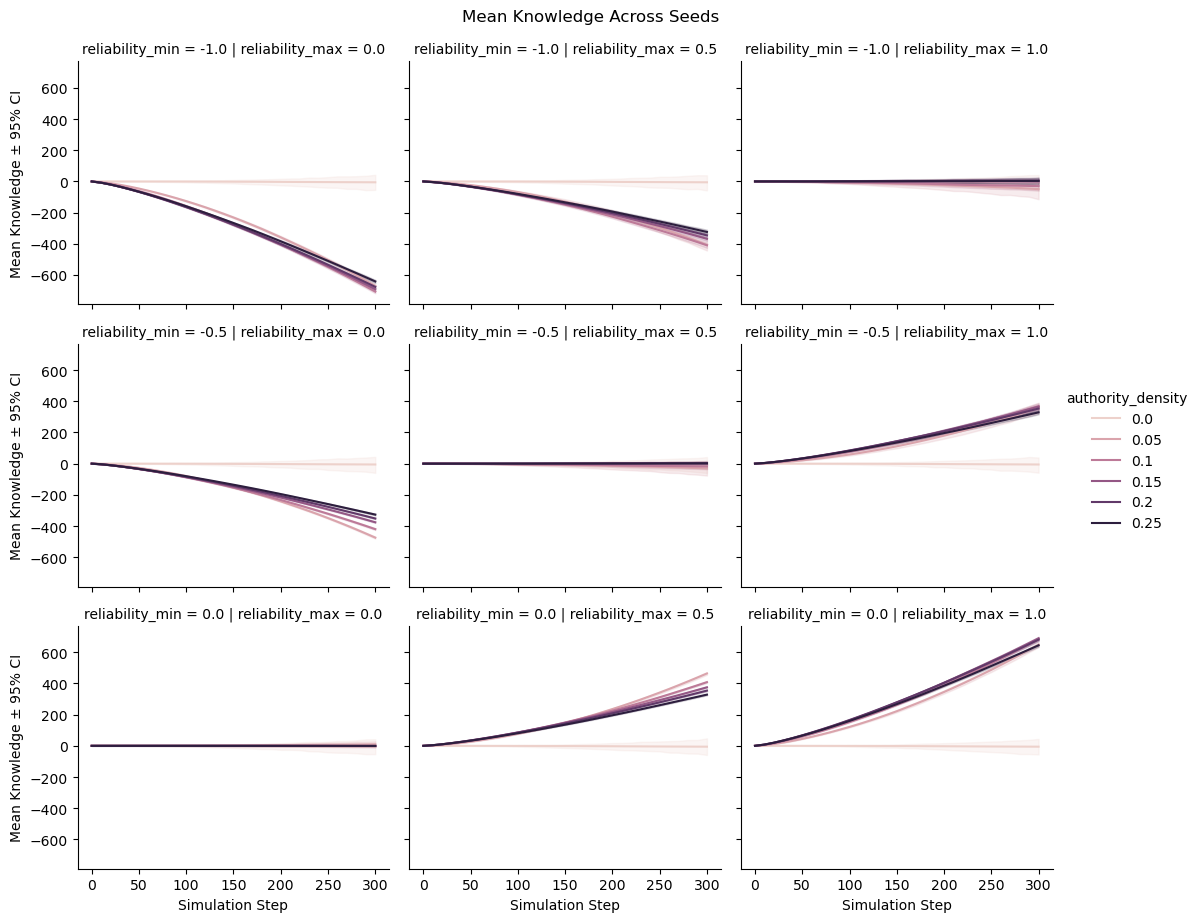

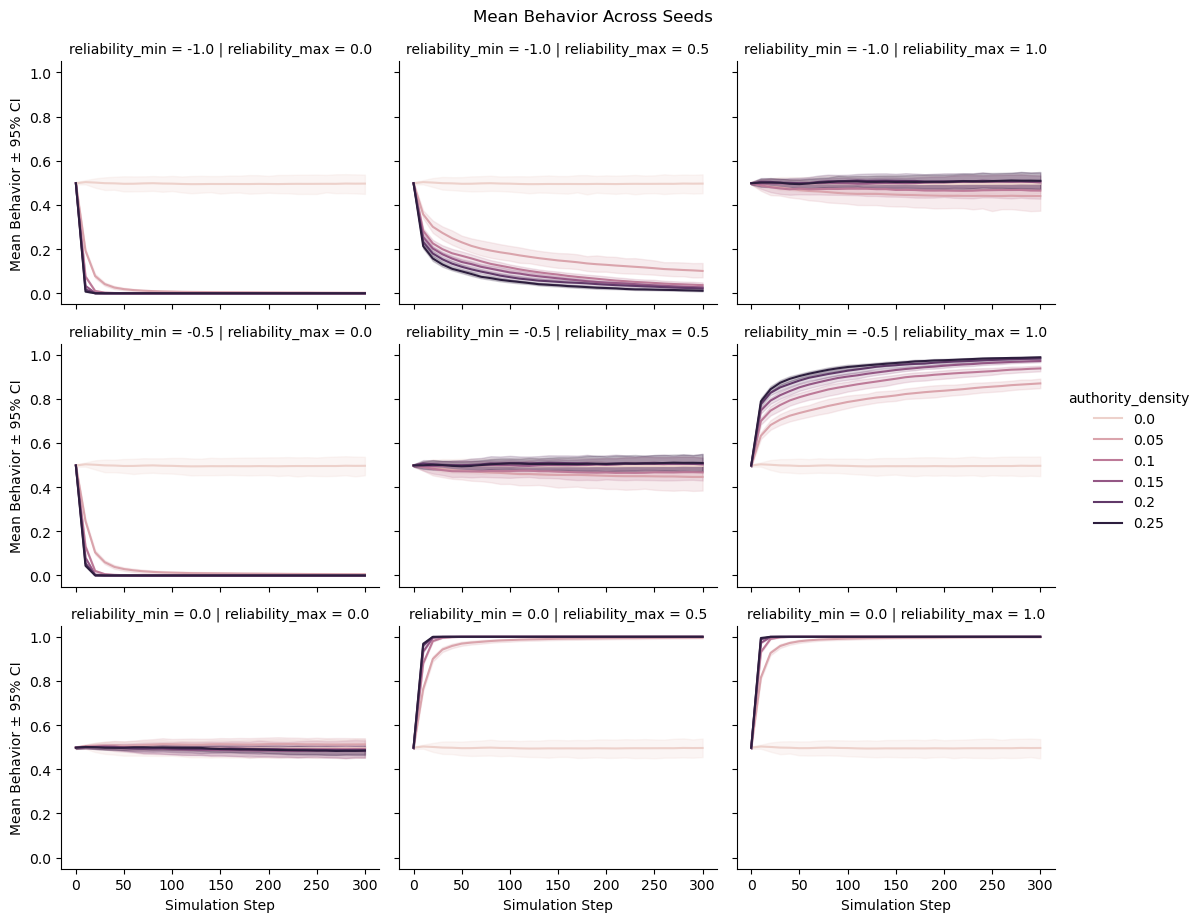

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

metrics = [
    ("Mean Knowledge", "Mean Knowledge"),
    ("Mean Behavior", "Mean Behavior"),
]

for colname, label in metrics:
    g = sns.relplot(
        data=df10, # pass in original df
        x="Step", y=colname,
        kind="line",
        hue="authority_density",
        col="reliability_max", row="reliability_min",
        errorbar=("ci", 95), # automatically averages over seeds
        height=3, aspect=1.2,
        facet_kws={"sharey": True} # give them all the same y-axis
    )
    g.set_axis_labels("Simulation Step", f"{label} ± 95% CI")
    g.fig.suptitle(f"{label} Across Seeds", y=1.02)
    plt.show()

Mean Behavior and Net Health Belief produce identical plots when averaged across the seeds, so I chose to only show the output for Mean Behavior here. You can see more variation in behavior from step to step when directly comparing the behavior and health belief plots for a single run in the GUI. For instance, see the image below (which shows the mean behavior and net health belief plots for a run with authority_density=0 and seed=0). The image demonstrates a generally similar curve for both plots, but the mean behavior plot is less smooth from step to step than the net health belief plot.
![image](/Users/haileyhansen/MACSS/40550/ABM_SP25/final_project/results/MB_NHB_ex.png)

The next step is the process I used to calculate convergence, grouped by authority density, across model runs.

In [ ]:
def compute_convergence_step(group, threshold=0.001, window=10): # ChatGPT helped me with this function
    ''' 
    The model converges when it has had average behavior
    changes of less than 0.001 for 10 consecutive steps
    '''
    behavior = group["Mean Behavior"].values
    steps = group["Step"].values

    deltas = np.abs(np.diff(behavior))

    for i in range(len(deltas) - window + 1):
        if np.all(deltas[i:i+window] < threshold):
            return steps[i + window]  
    return np.nan

# Apply to each run
convergence_df = df.groupby("RunId").apply(compute_convergence_step).reset_index()
convergence_df.columns = ["RunId", "ConvergenceStep"]
run_meta = df.groupby("RunId")[["authority_density", "reliability_min", "reliability_max"]].first().reset_index()
convergence_df = convergence_df.merge(run_meta, on="RunId")

/var/folders/_y/p8r1pq5s491gjhlr2x0pt9mc0000gn/T/ipykernel_4383/309662634.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  convergence_df = df.groupby("RunId").apply(compute_convergence_step).reset_index()


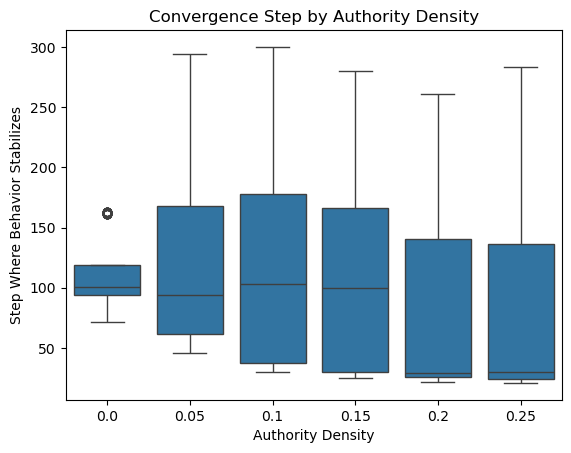

In [5]:
sns.boxplot(data=convergence_df, x="authority_density", y="ConvergenceStep")
plt.title("Convergence Step by Authority Density")
plt.ylabel("Step Where Behavior Stabilizes")
plt.xlabel("Authority Density")
plt.show()